## Red Compleja
Con esta red se obtuvo un Accuracy en Test de 0.629. La red consta de 12 capas convolucionales con MaxPooling y 2 capas densas.

In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import tensorflow.compat.v2 as tf
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow_datasets as tfds
from keras import backend as K
from tensorflow.python.keras.utils import np_utils
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rn2021q1itba-cifar100/submission_example.csv
/kaggle/input/rn2021q1itba-cifar100/y_train.npy
/kaggle/input/rn2021q1itba-cifar100/x_test.npy
/kaggle/input/rn2021q1itba-cifar100/x_train.npy


### Importación de datos

In [14]:
x_train_val = np.load("/kaggle/input/rn2021q1itba-cifar100/x_train.npy")
x_test = np.load("/kaggle/input/rn2021q1itba-cifar100/x_test.npy")
y_train_val = np.load("/kaggle/input/rn2021q1itba-cifar100/y_train.npy")

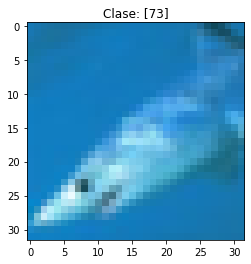

In [15]:
from matplotlib import pyplot as plt
#Mostramos alguna imágen
idx = 50
plt.imshow(x_train_val[idx])
plt.title(f'Clase: {y_train_val[idx]}')
plt.show()

In [16]:
#Dividimos entre train y validación
from sklearn.model_selection import train_test_split
x_train_val = x_train_val.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train, x_val, y_train, y_val = train_test_split(
     x_train_val, y_train_val, test_size=0.15, random_state=42, stratify=y_train_val)

In [17]:
x_train = x_train.reshape(x_train.shape[0], 32, 32, 3)
x_val = x_val.reshape(x_val.shape[0], 32, 32, 3)
x_test = x_test.reshape(x_test.shape[0], 32, 32, 3)

y_train = np_utils.to_categorical(y_train, 100)
y_val = np_utils.to_categorical(y_val, 100)

### Red de clasificación

In [18]:
from tensorflow.keras.layers import Dense, Flatten, Activation, BatchNormalization, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback, TensorBoard
from tensorflow.keras.optimizers import Adam, Nadam, SGD
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras import activations
from keras import regularizers
from keras import optimizers
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator  
import keras


In [ ]:
#Parámetros
num_classes = 100
weight_decay = 0.0005
x_shape = [32,32,3]
batch_size = 128
maxepoches = 130
learning_rate = 0.1
lr_decay = 1e-6
lr_drop = 20

def add_layer(model, convSize, dropOut = -1, maxPooling = False):
    model.add(Conv2D(convSize, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.0005)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    if (dropOut != -1):
        model.add(Dropout(dropOut))
    if (maxPooling):
        model.add(MaxPooling2D(pool_size=(2, 2)))

model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same',
                 input_shape=[32,32,3],kernel_regularizer=regularizers.l2(0.0005)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

add_layer(model, 64, maxPooling = True)
add_layer(model, 128, dropOut = 0.4)
add_layer(model, 128, maxPooling = True)
add_layer(model, 256, dropOut = 0.4)
add_layer(model, 256, dropOut = 0.4)
add_layer(model, 256, maxPooling = True)
add_layer(model, 512, dropOut = 0.4)
add_layer(model, 512, dropOut = 0.4)
add_layer(model, 512, maxPooling = True)
add_layer(model, 512, dropOut = 0.4)
add_layer(model, 512, dropOut = 0.4)
add_layer(model, 512, maxPooling = True)

model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512,kernel_regularizer=regularizers.l2(0.0005)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Dropout(0.5))
model.add(Dense(100))
model.add(Activation('softmax'))

#### Callbacks

In [ ]:
def lr_scheduler(epoch):
    return learning_rate * (0.5 ** (epoch // lr_drop))
reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)

#### Data Augmentation

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=15, 
    width_shift_range=0.1,
    height_shift_range=0.1
    horizontal_flip=True) 

datagen.fit(x_train)

#### Entrenamiento

In [20]:
sgd = optimizers.SGD(lr=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])

hist = model.fit(datagen.flow(x_train, y_train,
                                 batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=maxepoches,
                    validation_data=(x_val, y_val),callbacks=[reduce_lr])

Epoch 1/130
332/332 [==============================] - 132s 392ms/step - loss: 23.4600 - accuracy: 0.0173 - val_loss: 18.0720 - val_accuracy: 0.0109
Epoch 2/130
332/332 [==============================] - 129s 388ms/step - loss: 15.5240 - accuracy: 0.0423 - val_loss: 11.3738 - val_accuracy: 0.0237
Epoch 3/130
332/332 [==============================] - 129s 388ms/step - loss: 9.9447 - accuracy: 0.0531 - val_loss: 8.4537 - val_accuracy: 0.0263
Epoch 4/130
332/332 [==============================] - 129s 388ms/step - loss: 7.0876 - accuracy: 0.0706 - val_loss: 6.3503 - val_accuracy: 0.0425
Epoch 5/130
332/332 [==============================] - 129s 388ms/step - loss: 5.8666 - accuracy: 0.0650 - val_loss: 5.7970 - val_accuracy: 0.0515
Epoch 6/130
332/332 [==============================] - 129s 389ms/step - loss: 5.0000 - accuracy: 0.0869 - val_loss: 5.3633 - val_accuracy: 0.0487
Epoch 7/130
332/332 [==============================] - 129s 388ms/step - loss: 4.5174 - accuracy: 0.0998 - val_los

In [33]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_60 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_56 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
dropout_40 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_61 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_57 (Batc (None, 32, 32, 64)       

### Test

In [23]:
y_test = model.predict(x_test).argmax(axis=-1)

In [24]:
y_test

array([90, 33, 55, ..., 51, 42, 70])

In [25]:
#Salvo las predicciones y genero el archivo csv según el formato pedido
df = pd.DataFrame(y_test, columns=["label"])
df.index.name = "Id"
df.to_csv("submission_vgg2.csv")